<a href="https://colab.research.google.com/github/ChapelFob80930/GenAI-Lab/blob/main/Experiment_3_(GAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 877.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        self.fc4 = nn.Linear(512, 1024)
        self.fc5 = nn.Linear(1024, 28*28)  # Output size for MNIST
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        x = self.relu(self.fc1(z))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))  # Output values between -1 and 1
        return x.view(x.size(0), 1, 28, 28)  # Reshape to image size (1x28x28)


In [ ]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return self.fc4(x)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 348kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.12MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 809kB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
def wasserstein_loss(y_true, y_pred):
    return torch.mean(y_true * y_pred)


In [ ]:
def compute_gradient_penalty(critic, real_images, fake_images, device):
    batch_size, C, H, W = real_images.size()
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated_images.requires_grad_(True)

    critic_outputs = critic(interpolated_images)
    gradients = torch.autograd.grad(
        outputs=critic_outputs, inputs=interpolated_images,
        grad_outputs=torch.ones_like(critic_outputs),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    penalty = ((gradient_norm - 1) ** 2).mean()

    return penalty


Epoch [0/100], Generator Loss: -1.9005788564682007, Critic Loss: -9.143840789794922


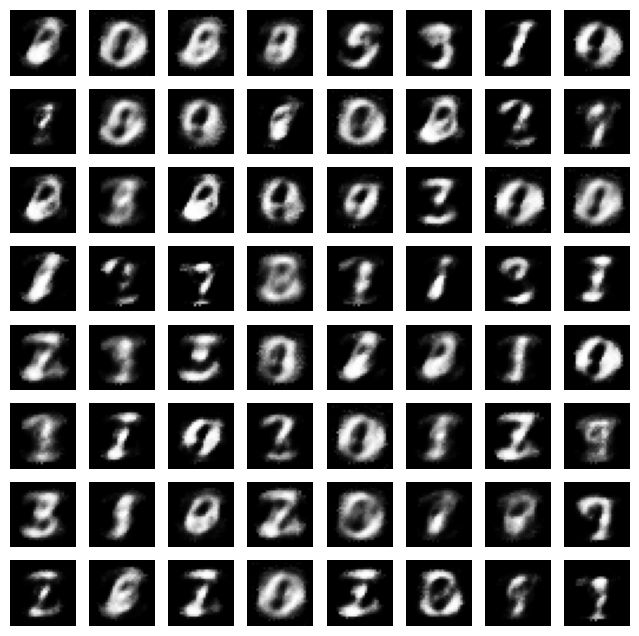

Epoch [1/100], Generator Loss: 6.686063289642334, Critic Loss: -8.157964706420898
Epoch [2/100], Generator Loss: 7.740452289581299, Critic Loss: -9.371378898620605
Epoch [3/100], Generator Loss: 6.606646537780762, Critic Loss: -8.814336776733398
Epoch [4/100], Generator Loss: 4.429615020751953, Critic Loss: -6.938131332397461
Epoch [5/100], Generator Loss: 3.4000020027160645, Critic Loss: -6.480020523071289
Epoch [6/100], Generator Loss: 1.8479408025741577, Critic Loss: -6.945112705230713
Epoch [7/100], Generator Loss: 2.937896251678467, Critic Loss: -6.26785945892334
Epoch [8/100], Generator Loss: 2.483034133911133, Critic Loss: -6.498284339904785
Epoch [9/100], Generator Loss: 1.6866419315338135, Critic Loss: -5.819646835327148
Epoch [10/100], Generator Loss: 3.1611745357513428, Critic Loss: -6.5927205085754395


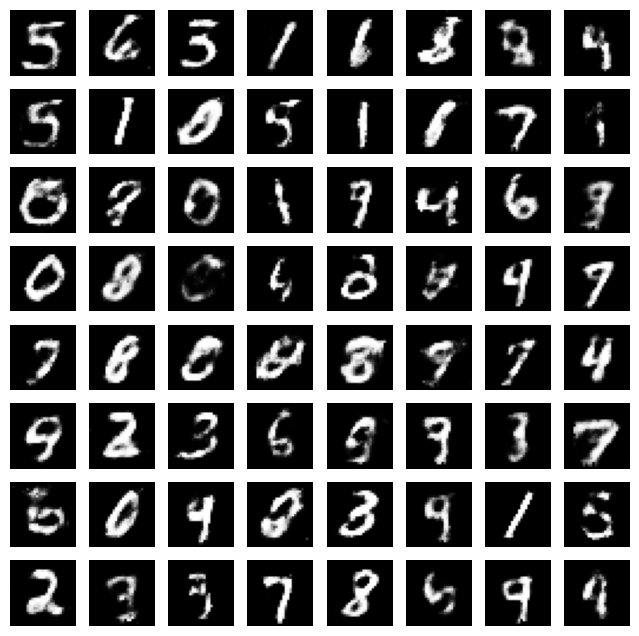

Epoch [11/100], Generator Loss: 2.0852270126342773, Critic Loss: -4.78326940536499
Epoch [12/100], Generator Loss: 2.4958302974700928, Critic Loss: -5.188096523284912
Epoch [13/100], Generator Loss: 3.3984766006469727, Critic Loss: -5.383625507354736
Epoch [14/100], Generator Loss: 1.8590129613876343, Critic Loss: -4.174747943878174
Epoch [15/100], Generator Loss: 3.006671667098999, Critic Loss: -5.2013444900512695


In [ ]:
# Hyperparameters
z_dim = 100  # Latent vector size
lr = 0.00005  # Learning rate
n_critic = 5  # Number of critic updates per generator update
lambda_gp = 10  # Gradient penalty lambda

# Initialize models and optimizers
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

# Training Loop
epochs = 100
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Critic
        for _ in range(n_critic):
            z = torch.randn(batch_size, z_dim).to(device)
            fake_images = generator(z)

            critic_real = critic(real_images)
            critic_fake = critic(fake_images)

            # Compute gradient penalty
            gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

            # Critic loss
            critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake) + lambda_gp * gradient_penalty

            optim_critic.zero_grad()
            critic_loss.backward()
            optim_critic.step()

        # Train Generator
        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = generator(z)
        critic_fake = critic(fake_images)

        # Generator loss
        gen_loss = -torch.mean(critic_fake)

        optim_gen.zero_grad()
        gen_loss.backward()
        optim_gen.step()

    print(f"Epoch [{epoch}/{epochs}], Generator Loss: {gen_loss.item()}, Critic Loss: {critic_loss.item()}")

    # Visualize generated images
    if epoch % 10 == 0:
        with torch.no_grad():
            test_z = torch.randn(64, z_dim).to(device)
            generated_images = generator(test_z)
            generated_images = generated_images.cpu().data
            generated_images = generated_images.view(64, 28, 28)

            plt.figure(figsize=(8, 8))
            for i in range(64):
                plt.subplot(8, 8, i+1)
                plt.imshow(generated_images[i], cmap='gray')
                plt.axis('off')
            plt.show()
